In [1]:
import os
import glob
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme(style="whitegrid")

pd.options.display.max_rows = 200

os.chdir('/mnt/BioAdHoc/Groups/vd-ay/jreyna/projects/Loop-Catalog-SGLs/')

outdir = 'results/hg38/finemapping/sgls_summary/'
os.makedirs(outdir, exist_ok=True)

#### Adding gene information

In [2]:
old_fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.w_genetypes.bed'
fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.genes_only.bed.gz'
gencode_df = pd.read_table(fn, header=None)
gencode_df = gencode_df.iloc[:, [0,1,2,5,6,7,8]]
gencode_df.columns =['chrom', 'start', 'end', 'strand', 'genename', 'geneid', 'genetype']
# gencode_df = gencode_df.loc[gencode_df.type == 'gene'].drop('type', axis=1)
gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
/mnt/BioHome/jreyna/tmp/ipykernel_2221860/3830488000.py:7: SyntaxWarning: invalid escape sequence '\.'
  gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)


In [3]:
gencode_df

,chrom,start,end,strand,genename,geneid,genetype
0,chr1,11868,14409,+,DDX11L1,ENSG00000223972,transcribed_unprocessed_pseudogene
1,chr1,14403,29570,-,WASH7P,ENSG00000227232,unprocessed_pseudogene
2,chr1,17368,17436,-,MIR6859-1,ENSG00000278267,miRNA
3,chr1,29553,31109,+,MIR1302-2HG,ENSG00000243485,lincRNA
4,chr1,30365,30503,+,MIR1302-2,ENSG00000284332,miRNA
...,...,...,...,...,...,...,...
58865,chrY,57184100,57197337,+,IL9R,ENSG00000124334_PAR_Y,protein_coding
58866,chrY,57190737,57208756,+,AJ271736.1,ENSG00000270726_PAR_Y,processed_transcript
58867,chrY,57201142,57203357,-,WASIR1,ENSG00000185203_PAR_Y,antisense
58868,chrY,57207345,57212230,+,WASH6P,ENSG00000182484_PAR_Y,transcribed_unprocessed_pseudogene


## Load all SGL Data


In [4]:
#fns = glob.glob('results/hg38/finemapping/sgls/*/Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1.5000.finemap_sgls.tsv')
fns = glob.glob('results/hg38/finemapping/sgls/*/*.finemap_sgls.tsv')

# # removing all donors for this analysis
# fns = [x for x in fns if 'All-Donors' not in x]

# # removign all biorep donors from this analysis
# fns = [x for x in fns if 'biorep_merged' not in x]

In [5]:
all_data = []
for fn in fns:
    
    # split meta information
    info = fn.split('/')
    genome = info[1]
    causaldb_fn = info[4]
    sample = info[5].rsplit('.', maxsplit=3)[0]

    # load sgl table
    tdf = pd.read_table(fn)
    tdf.loc[:, 'causaldb_fn'] = causaldb_fn
    tdf.loc[:, 'sample'] = sample

    # append to all
    all_data.append(tdf)

all_df = pd.concat(all_data)
all_df.rename(columns={'-log10_qval': '-log10_qval_loop'}, inplace=True)

In [6]:
all_df.head(3)

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,label,causaldb_fn,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,sample
0,1,113830000,113835000,1,113925000,113930000,4.663678,1,113834945,113834946,...,7.0,CA266,AnchorA,1,113929323,113929324,HIPK1,ENSG00000163349,+,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...
1,1,113830000,113835000,1,113925000,113930000,4.663678,1,113834945,113834946,...,7.0,CA266,AnchorA,1,113929491,113929492,HIPK1-AS1,ENSG00000235527,-,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...
2,12,56040000,56045000,12,56100000,56105000,5.029779,12,56041627,56041628,...,7.0,CA266,AnchorA,12,56101330,56101331,AC034102.2,ENSG00000257411,+,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...


In [7]:
# load meta information
causal_metadata_fn = 'workflow/scripts/finemap_sgls/causal_db/init.gwas_study.causal_db.immune_select_samples.tsv'
causal_metadata = pd.read_table(causal_metadata_fn, header=None)

# merge meta data
causal_metadata_mapper =  causal_metadata.iloc[:, [2, 8, 18]]
causal_metadata_mapper.columns = ['mesh_term', 'author', 'filename']
all_df = all_df.merge(causal_metadata_mapper, left_on='causaldb_fn', right_on='filename')

# add snp position
all_df['snp_pos'] = all_df['chrom'].astype(str) + ':' + all_df['end_snp'].astype(str)

In [8]:
all_df.head()

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos
0,1,113830000,113835000,1,113925000,113930000,4.663678,1,113834945,113834946,...,113929323,113929324,HIPK1,ENSG00000163349,+,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113834946
1,1,113830000,113835000,1,113925000,113930000,4.663678,1,113834945,113834946,...,113929491,113929492,HIPK1-AS1,ENSG00000235527,-,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,1:113834946
2,12,56040000,56045000,12,56100000,56105000,5.029779,12,56041627,56041628,...,56101330,56101331,AC034102.2,ENSG00000257411,+,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:56041628
3,12,56040000,56045000,12,56100000,56105000,5.029779,12,56041627,56041628,...,56104536,56104537,PA2G4,ENSG00000170515,+,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:56041628
4,12,56040000,56045000,12,56100000,56105000,5.029779,12,56041719,56041720,...,56101330,56101331,AC034102.2,ENSG00000257411,+,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:56041720


#### Mini-summary

In [9]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
t.shape

(28595, 37)

In [10]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'sample'])
t.shape

(147422, 37)

In [11]:
# count the samples
num_samples = all_df['sample'].nunique()
print('Number of samples with SGLs:', num_samples)

# count the total number of sgl events across all studies
print('Number of SGL events:', all_df.shape[0]) 

# count the unique snps
num_uniq_snps = (all_df['chrA_loop'].astype(str) + '-' + all_df['end_snp'].astype(str)).nunique()
print('Number of unique snps:', num_uniq_snps)

# count the unique genes
num_uniq_genes = all_df.geneid.nunique()
print('Number of unique genes:', num_uniq_genes)

# count the unique loops
uniq_loops_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop'])
print('Number of unique loops:', uniq_loops_df.shape[0])

# count the total number of sgls
uniq_sgls_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid'])
print('Number of unique sgls:', uniq_sgls_df.shape[0])

Number of samples with SGLs: 74
Number of SGL events: 182306
Number of unique snps: 4241
Number of unique genes: 2354
Number of unique loops: 7269
Number of unique sgls: 28162


Also want to look at the number of SNPs we started with

In [12]:
num_snps_study = pd.read_table('results/hg38/finemapping/snps/singles/num_snps.tsv', header=None)
num_snps_study.columns = ['num_snps', 'filename']
num_snps_study = num_snps_study.merge(causal_metadata_mapper)
num_snps_study_mesh = num_snps_study.groupby('mesh_term').sum()
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


Looking into the average distance

In [52]:
dist = (all_df.startB_loop - all_df.startA_loop)

In [54]:
dist.describe().astype(int)

count     182306
mean      363413
std       495946
min        20000
25%        60000
50%       140000
75%       375000
max      2000000
dtype: int64

<Axes: ylabel='Frequency'>

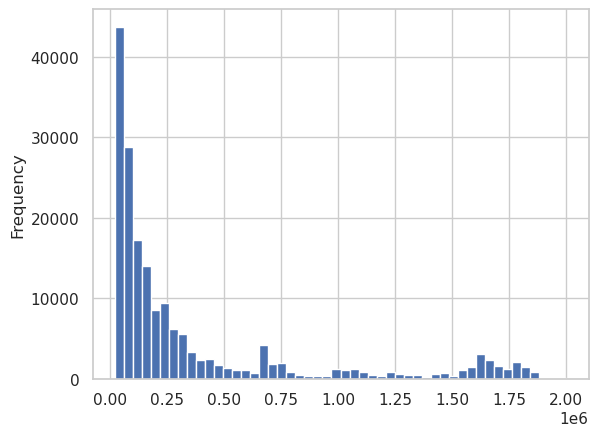

In [60]:
dist.plot(kind='hist', bins=50)

## Overview of SGLs Across Each Disease

### Count the number of sgls per GWAS Study

I would expect that, in general, that studies with more snps will have more SGLs.

In [13]:
grps = all_df.groupby(['causaldb_fn', 'mesh_term', 'author'])
counts = grps['chrA_loop'].count().to_frame()
counts.columns = ['num_sgls']

In [14]:
counts.sort_values(['mesh_term', 'num_sgls'], ascending=[True, False])

,,,num_sgls
causaldb_fn,mesh_term,author,
PH378,"Arthritis, Rheumatoid",Okada Y,17692
AT452,"Arthritis, Rheumatoid",Roslin Institute,7790
CA104,"Arthritis, Rheumatoid",Eyre S,5359
AT551,"Arthritis, Rheumatoid",Roslin Institute,5136
CA391,"Arthritis, Rheumatoid",Stahl EA,1391
BE151,"Arthritis, Rheumatoid",Nealelab,956
AT454,"Arthritis, Rheumatoid",Roslin Institute,604
GD09159,"Dermatitis, Atopic",Sliz E,14765
GD08996,"Diabetes Mellitus, Type 1",Chiou J,34873


In [15]:
counts.describe()

,num_sgls
count,18.000000
mean,10128.111111
std,10016.671320
min,604.000000
25%,3619.750000
50%,7763.500000
75%,13533.000000
max,34873.000000


### Count and plot the number of sgls, snps and genes per mesh term

In [16]:
uniq_sgls_mesh_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startA_loop'].astype(str) + '--' \
                            + uniq_sgls_mesh_df['chrB_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startB_loop'].astype(str)

mesh_sgl_grps = uniq_sgls_mesh_df.groupby(['mesh_term'])
sgl_counts = mesh_sgl_grps['loop_id'].count().to_frame()
sgl_counts.columns = ['num_sgls']
sgl_counts.sort_values('num_sgls', ascending=False)

/mnt/BioHome/jreyna/tmp/ipykernel_2221860/4268753814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \


,num_sgls
mesh_term,
"Diabetes Mellitus, Type 1",16534
"Arthritis, Rheumatoid",6122
"Dermatitis, Atopic",3257
Psoriasis,2682


In [17]:
# number of unique genes per mesh term
mesh_gene_grps = uniq_sgls_mesh_df.drop_duplicates(['geneid', 'mesh_term']).groupby(['mesh_term'])
gene_counts = mesh_gene_grps['loop_id'].count().to_frame()
gene_counts.columns = ['num_genes']
gene_counts.sort_values('num_genes', ascending=False)

,num_genes
mesh_term,
"Diabetes Mellitus, Type 1",1546
Psoriasis,687
"Arthritis, Rheumatoid",589
"Dermatitis, Atopic",417


In [18]:
# number of unique snps per mesh term
mesh_snp_grps = uniq_sgls_mesh_df.drop_duplicates(['snp_pos', 'mesh_term']).groupby(['mesh_term'])
snp_counts = mesh_snp_grps['loop_id'].count().to_frame()
snp_counts.columns = ['num_snps']
snp_counts.sort_values('num_snps', ascending=False)

,num_snps
mesh_term,
"Diabetes Mellitus, Type 1",2884
"Arthritis, Rheumatoid",577
"Dermatitis, Atopic",536
Psoriasis,309


In [19]:
combine_uniq_mesh_counts = pd.concat([num_snps_study_mesh[['num_snps']], snp_counts, sgl_counts, gene_counts], axis=1)
combine_uniq_mesh_counts.columns = ['num_total_snps', 'num_snps', 'num_sgls', 'num_genes']
combine_uniq_mesh_counts

,num_total_snps,num_snps,num_sgls,num_genes
mesh_term,,,,
"Arthritis, Rheumatoid",1121,577,6122,589
"Dermatitis, Atopic",674,536,3257,417
"Diabetes Mellitus, Type 1",7729,2884,16534,1546
Psoriasis,590,309,2682,687


In [20]:
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


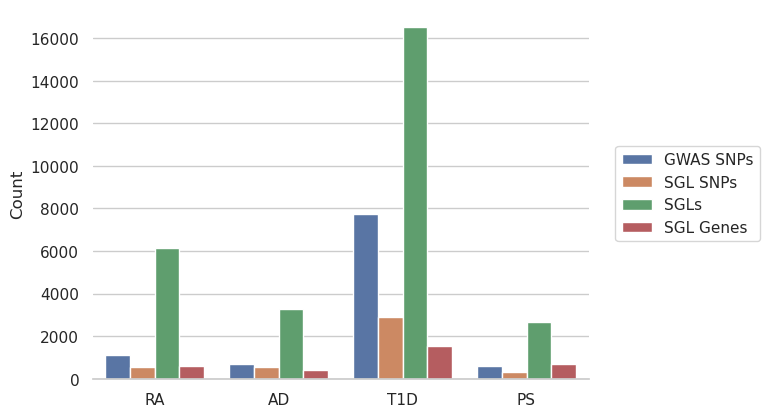

In [21]:
# extract data
plot_data = combine_uniq_mesh_counts.melt(ignore_index=False).reset_index()
plot_data.replace({'num_total_snps': 'GWAS SNPs', 'num_snps': 'SGL SNPs',
                    'num_genes': 'SGL Genes', 'num_sgls': 'SGLs',
                    'Arthritis, Rheumatoid': 'RA', 'Dermatitis, Atopic': 'AD',
                    'Diabetes Mellitus, Type 1': 'T1D', 'Psoriasis': 'PS'}, inplace=True)

# plot data
fig, ax = plt.subplots()

sns.barplot(plot_data, x='mesh_term', y='value', hue='variable', ax=ax)

# remove left spine
sns.despine(left=True)

# move legend
sns.move_legend(ax, "upper center", bbox_to_anchor=(1.2, 0.65))

# rotate X-Axis Ticks by 45-degrees
#ax.tick_params(axis='x', labelrotation = 75)

# set labels
ax.set_xlabel('')
ax.set_ylabel('Count')
legend = ax.legend_
legend.set_title('') 

outfn = os.path.join(outdir, 'sgl_breakdowns.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

We can see that Type 1 Diabetes has the most number of SGLs. 

In [22]:
mesh_grps = all_df.groupby(['mesh_term'])

In [23]:
def get_top_counts(df, n=10):
    sorted_df = df.genename.value_counts().iloc[0:n]
    return(sorted_df)
mesh_grps.apply(get_top_counts)

mesh_term                  genename  
Arthritis, Rheumatoid      Z84485.1       630
                           BRPF3          630
                           ARID5B         603
                           IER3           593
                           FLOT1          593
                           IER3-AS1       593
                           HIST1H2BN      484
                           HIST1H2AK      484
                           HIST1H4A       477
                           HIST1H3A       477
Dermatitis, Atopic         TRIB1          684
                           NFKBIA         500
                           MIR6090        435
                           HCG27          394
                           AL662844.4     394
                           AC009812.1     374
                           ZBTB10         374
                           AC034102.7     312
                           ESYT1          312
                           ZC3H10         312
Diabetes Mellitus, Type 1  APOBR         2

If we get the top SGLs based on genes we can see that gene such as NFKBIA are coming up.

In [24]:
cols = ['chrA_loop', 'startA_loop', 'endA_loop',
         'chrB_loop', 'startB_loop', 'endB_loop',
         '-log10_qval_loop', 'sample',
         'end_snp', 'snp_anchor', 
         'genename', 'geneid', 
         'mesh_term', 'author', 'causaldb_fn']

new_cols = ['ChrA', 'StartA', 'EndA',
             'ChrB', 'StartB', 'EndB',
             '-log10(Q values)', 'Sample Name',
             'SNP Pos', 'SNP Anchor', 
             'Gene Name', 'Gene ID', 
             'Mesh Term', 'Author', 'CAUSALdb Study ID']

# mesh_outfn = os.path.join(outdir, 'sgls.supplemental_table.xlsx')
# with pd.ExcelWriter(mesh_outfn) as fw:
#     for grp, grp_df in mesh_grps:
#         tdf = grp_df[cols].sort_values(['author', 'sample', 'chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'end_snp', 'geneid'])
#         tdf.loc[:, 'chrA_loop'] = 'chr' + tdf.loc[:, 'chrA_loop'].astype(str)
#         tdf.loc[:, 'chrB_loop'] = 'chr' + tdf.loc[:, 'chrB_loop'].astype(str)
#         tdf.columns = new_cols
#         tdf.to_excel(fw, sheet_name=grp[0], index=False)

## Diving into SGLs for T1D

In [25]:
t1d_df = mesh_grps.get_group('Diabetes Mellitus, Type 1')

In [26]:
t1d_df.geneid.nunique()

1546

In [27]:
sgl_viz_cols = ['chrom', 'end_snp',
                'genename', 'geneid', 'start_gene', 'end_gene',
                'startA_loop', 'startB_loop', '-log10_qval_loop',
                'sample', 'author']
t1d_df.sort_values(['-log10_qval_loop', 'chrom', 'end_snp'], ascending=[False, True, True])[sgl_viz_cols].head(10)

,chrom,end_snp,genename,geneid,start_gene,end_gene,startA_loop,startB_loop,-log10_qval_loop,sample,author
50273,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,THP-1-WT-Batch1.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
50274,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,THP-1-WT-Batch1.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
81842,8,140637192,TRAPPC9,ENSG00000167632,140458578,140458579,140455000,140635000,546.012211,CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,Chiou J
81841,8,140638981,TRAPPC9,ENSG00000167632,140458578,140458579,140455000,140635000,546.012211,CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,Chiou J
46353,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,THP-1-WT-Batch2.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
46354,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,THP-1-WT-Batch2.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
81921,8,140637192,CHRAC1,ENSG00000104472,140511310,140511311,140510000,140635000,482.900635,CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,Chiou J
81920,8,140638981,CHRAC1,ENSG00000104472,140511310,140511311,140510000,140635000,482.900635,CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,Chiou J
48709,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,THP-1-del-cIDR-Batch1.GSE149420.Homo_Sapiens.H...,Forgetta V
48710,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,THP-1-del-cIDR-Batch1.GSE149420.Homo_Sapiens.H...,Forgetta V


In [28]:
t1d_uniq_sgls = t1d_df.drop_duplicates(['chrA_loop', 'chrB_loop', 'startA_loop', 'startB_loop', 'geneid', 'start_snp'])

### Count and plot the number of sgls and snps per gene

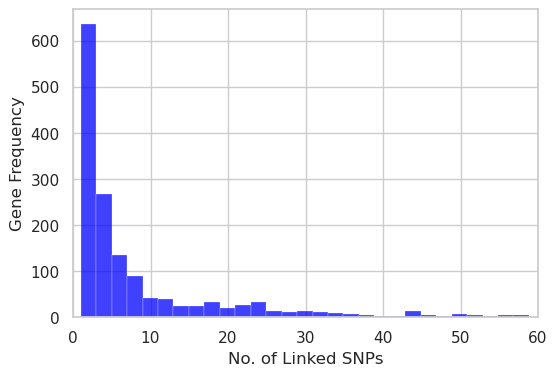

In [29]:
# getting the data
snps_per_gene = t1d_uniq_sgls.groupby('geneid').snp_pos.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme(style="whitegrid")
sns.histplot(snps_per_gene['snp_pos'], color='blue', binwidth=2, ax=ax, element='bars')

ax.set_xlim(0, 60)
ax.set_xlabel('No. of Linked SNPs')
ax.set_ylabel('Gene Frequency')
ax.set_title('')

outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')


In [30]:
snps_per_gene.snp_pos.describe()

count    1546.000000
mean       10.694696
std        20.013101
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       344.000000
Name: snp_pos, dtype: float64

In [31]:
((snps_per_gene.snp_pos.value_counts() / len(snps_per_gene)) * 100).head(10)

snp_pos
1     26.390686
2     14.747736
3      9.249677
4      8.020699
6      4.592497
5      4.204398
7      3.234153
8      2.522639
23     1.487710
10     1.358344
Name: count, dtype: float64

In [32]:
# tdf = snps_per_gene.snp_pos.sort_values(ascending=True).to_frame()
# tdf['pos'] = list(range(tdf.shape[0]))
# tdf.columns = ['num_linked_snps', 'pos']

# # plotting
# fig, ax = plt.subplots(figsize=(6,4))
# sns.set_theme(style="whitegrid")
# sns.scatterplot(tdf, x='pos', y='num_linked_snps', s=10)

# #ax.set_xlim(0, 60)
# ax.set_xlabel('Gene')
# ax.set_ylabel('No. of Linked SNPs')
# ax.set_title('')
# #ax.set_xticklabels([])
# # outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.png')
# # fig.savefig(outfn, dpi=600, bbox_inches='tight')


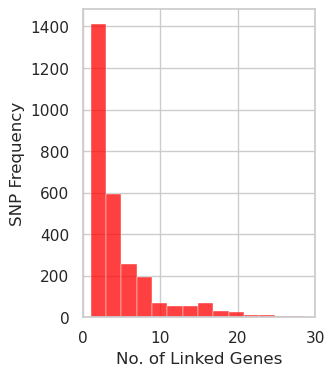

In [33]:
# getting the data
genes_per_snp = t1d_uniq_sgls.groupby('snp_pos').geneid.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(3,4))
sns.set_theme(style="whitegrid")
sns.histplot(genes_per_snp['geneid'], color='red', binwidth=2, ax=ax)

ax.set_xlim(0, 30)
ax.set_xlabel('No. of Linked Genes')
ax.set_ylabel('SNP Frequency')

outfn = os.path.join(outdir, 't1d_sgls.genes_per_snp.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

In [34]:
genes_per_snp.geneid.describe()

count    2884.000000
mean        5.733010
std        10.087725
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       104.000000
Name: geneid, dtype: float64

In [35]:
((genes_per_snp.geneid.value_counts() / len(genes_per_snp)) * 100).head(10)

geneid
1     27.461859
2     21.497920
3     11.858530
4      8.737864
5      6.067961
7      4.056865
6      2.808599
8      2.669903
9      1.525659
15     1.490985
Name: count, dtype: float64

### Compare to the Consensus Gene List

In [36]:
def print_genelist(genelist):
    print('\n'.join(list(genelist)))

#### Save a list of unique genes for T1D

In [37]:
# get the uniq T1D SGL genes
uniq_genes = t1d_df.genename.unique()
print('The unique number of genes is: {}'.format(len(uniq_genes)))

The unique number of genes is: 1532


In [38]:
'IL15RA' in uniq_genes

True

In [39]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(uniq_genes))
    fw.write(s)

#### Load the consensus T1D gene list

In [40]:
t1d_consensus_list_fn = '/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/projects/dchallenge/results/main/gene_lists/consensus_gene_list.txt'
t1d_consensus_genes = pd.read_table(t1d_consensus_list_fn, header=None, names=['genename'])
print('The number of consensus genes is: {}'.format(t1d_consensus_genes.shape[0]))

The number of consensus genes is: 497


In [41]:
'IL15' in t1d_consensus_genes.genename.tolist()

True

In [42]:
t1d_consensus_genes

,genename
0,APOB
1,PI4KA
2,PSMB8
3,AMBP
4,CD6
...,...
492,KLF3-AS1
493,CTRB2
494,CLN3
495,IL6R


#### Overlap the SGL genes with the consensus genes 

In [43]:
t1d_plus_consensus_df = t1d_df.loc[t1d_df.genename.isin(t1d_consensus_genes.iloc[:, 0].tolist())]

In [44]:
shared_t1d_plus_consensus_genes = sorted(t1d_plus_consensus_df.genename.unique().tolist())
print('The unique number of shared genes is: {}'.format(len(shared_t1d_plus_consensus_genes)))

The unique number of shared genes is: 106


In [45]:
all_t1d_genes = set(t1d_df.genename.tolist())

In [46]:
only_t1d_genes = all_t1d_genes.difference(shared_t1d_plus_consensus_genes)

In [47]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'left_venn_only.uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(only_t1d_genes))
    fw.write(s)

In [48]:
7 + 

SyntaxError: invalid syntax (811582240.py, line 1)

## Investigating Shared Genes

In [ ]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get shared genes for T1D
shared_gene_df = base_genes_df.loc[base_genes_df.genename.isin(shared_t1d_plus_consensus_genes)]

# set associated sgls
shared_gene_sgls = t1d_df.loc[all_df.geneid.isin(shared_gene_df.geneid.tolist())]

# testing the removal of hist proteins
shared_gene_sgls = shared_gene_sgls.loc[~shared_gene_sgls.genename.str.contains('HIST')]

# add distance 
shared_gene_sgls.loc[:, 'distance'] = shared_gene_sgls.loc[:, 'startB_loop'] - shared_gene_sgls.loc[:, 'startA_loop']

In [ ]:
shared_gene_sgls

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos,distance
18,12,111405000,111410000,12,111445000,111450000,8.225973,12,111446803,111446804,...,111405948,SH2B3,ENSG00000111252,+,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:111446804,40000
19,13,99305000,99310000,13,99425000,99430000,10.171024,13,99429511,99429512,...,99307399,GPR183,ENSG00000169508,-,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,13:99429512,120000
21,16,28490000,28495000,16,28535000,28540000,5.411512,16,28494338,28494339,...,28539174,NUPR1,ENSG00000176046,-,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339,45000
25,6,90140000,90145000,6,90295000,90300000,8.993829,6,90140444,90140445,...,90296908,BACH2,ENSG00000112182,-,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,6:90140445,155000
26,6,90140000,90145000,6,90295000,90300000,8.993829,6,90142538,90142539,...,90296908,BACH2,ENSG00000112182,-,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,6:90142539,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182262,5,35830000,35835000,5,35850000,35855000,22.439913,5,35833520,35833521,...,35852695,IL7R,ENSG00000168685,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,5:35833521,20000
182263,5,35850000,35855000,5,35920000,35925000,13.997801,5,35921967,35921968,...,35852695,IL7R,ENSG00000168685,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,5:35921968,70000
182264,5,35850000,35855000,5,35920000,35925000,13.997801,5,35924645,35924646,...,35852695,IL7R,ENSG00000168685,+,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,5:35924646,70000
182283,6,90170000,90175000,6,90295000,90300000,5.432919,6,90170673,90170674,...,90296908,BACH2,ENSG00000112182,-,CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,6:90170674,125000


In [ ]:
# calculating genes which are present in SGLs across more than 3 samples
shared_gene_freqs = shared_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
shared_genes_high_freq = shared_gene_freqs[shared_gene_freqs > 3]
shared_genes_high_freq_list = shared_genes_high_freq.index.tolist()

In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = []
candidates = shared_gene_sgls.loc[shared_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(shared_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

# display(candidates.iloc[:, 14:])
# #pd.options.display.max_rows = 200


In [ ]:
candidates.genename.unique()

array(['RAD51B', 'SMARCE1', 'IKZF3', 'CCR7', 'CCRL2', 'ITSN2', 'ATXN2L',
       'NCOA1', 'PSMB2', 'CCR5', 'SBK1'], dtype=object)

In [ ]:
7 +

SyntaxError: invalid syntax (431988044.py, line 1)

## Investigate Novel Genes

In [ ]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get novel genes for T1D
novel_gene_df = base_genes_df.loc[base_genes_df.genename.isin(only_t1d_genes)]

# set associated sgls
novel_gene_sgls = t1d_df.loc[all_df.geneid.isin(novel_gene_df.geneid.tolist())]

# testing the removal of hist proteins
novel_gene_sgls = novel_gene_sgls.loc[~novel_gene_sgls.genename.str.contains('HIST')]

# add distance 
novel_gene_sgls.loc[:, 'distance'] = novel_gene_sgls.loc[:, 'startB_loop'] - novel_gene_sgls.loc[:, 'startA_loop']

In [ ]:
#print(','.join(list(novel_gene_sgls.geneid.unique())))

In [ ]:
# counting snp-gene pairs 
novel_gene_sgls.loc[:, 'sgname'] = novel_gene_sgls.loc[:, 'genename'] + ' & ' + novel_gene_sgls.loc[:, 'snp_pos']
sgpair_counts = novel_gene_sgls.sgname.value_counts().to_frame()

I'm interested in the frequency of each SNP + gene pair. Hopefully there is a pair with lots of samples. 

In [ ]:
sgl_freqs = sgpair_counts.sort_index()['count'].unique()
sgl_freqs

array([  2,   1,  18,   9,   8,  10,   5,   4,   6,   3,  30,  12,  45,
        19,  15,  35,  14, 100,  40,   7,  24,  11,  20,  34,  53,  65,
        52,  39,  13,  70,  28,  38,  76,  60,  90,  21, 212,  22,  41,
        23,  16,  17,  36,  32,  27,  44,  43,  25,  96,  29, 170,  68,
        37,  75, 126,  26,  48, 138,  42,  80,  69, 120,  54,  57,  33,
       117, 102,  46, 106, 318, 156,  64, 150,  55,  84,  31])

In [ ]:
pd.options.display.max_rows = 100
display(sgpair_counts)
pd.options.display.max_rows = 100

,count
sgname,
SGF29 & 16:28494339,318
APOBR & 16:28554346,212
AC138894.1 & 16:28554837,212
AC138894.1 & 16:28554346,212
APOBR & 16:28554837,212
...,...
CEP192 & 18:12841177,1
CEP192 & 18:12843264,1
CCDC157 & 22:30116269,1


In [ ]:
# calculating genes which are present in SGLs across more than 3 samples
novel_gene_freqs = novel_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
novel_genes_high_freq = novel_gene_freqs[novel_gene_freqs > 3]
novel_genes_high_freq_list = novel_genes_high_freq.index.tolist()

In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = ['CD63', 'AC009779.2', 'AC073896.2', 'AC145285.3', 'SETD9', 'PUM3', 'AC022506.1', 'DDIT3', 'MBD6', 'PKNOX1', 'GPBP1']
check_genes += ['SLC30A1', 'ZBTB37', 'EIF1', 'CENPL', 'DARS2', 'ZFYVE26', 'KMT2E', 'NIPBL', 'BRIX1', 'RAD1', 'LONRF1']
check_genes += ['RAPGEF6', 'ITGB1', 'FAM210A', 'RNMT', 'DTL', 'INTS7', 'SIMM12', 'EPC1', 'SMIM12', 'NUDT6']
check_genes += ['RFX3', 'SPATA5', 'DUSP28', 'HSPA4', 'ZIC2', 'ANKMY1', 'RNPEPL1', 'ZSCAN22', 'FKBP1B']
check_genes += ['WDCP', 'SFPQ', 'CYP20A1', 'DOCK9', 'NCK1', 'FANCI', 'RRP1', 'STK40', 'AFG3L2']
check_genes += ['STAG1', 'NEK7', 'UBE2G2', 'RO60', 'DNAJC27', 'TNFSF4', 'ABHD2', 'IFT27', 'GDF9', 'UQCRQ']
check_genes += ['PRKAR1A', 'WIPI1', 'NCF4', 'TRAPPC10', 'PTRHD1', 'HAPLN3', 'HEXIM2', 'KIF14', 'UBAC2']
check_genes += ['GDF11', 'STARD3', 'SECISBP2', 'RARA', 'CCR1', 'CCR2', 'ORMDL2', 'SENP3', 'SENP3-EIF4A1']
candidates = novel_gene_sgls.loc[novel_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(novel_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

#display(candidates.iloc[:, 14:])
#pd.options.display.max_rows = 200


In [ ]:
for x in candidates.genename.unique():
    print(x)
    break

MTF1


In [ ]:
nck1 = candidates.loc[candidates.genename == 'NCK1']
nck1

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chr_snp,start_snp,end_snp,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,causaldb_fn,sample,mesh_term,author,filename,snp_pos,sgname,distance
83310,3,136250000,136255000,3,136860000,136865000,8.139618,3,136254605,136254606,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136254606,NCK1 & 3:136254606,610000
83312,3,136250000,136255000,3,136860000,136865000,8.139618,3,136250752,136250753,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136250753,NCK1 & 3:136250753,610000
85688,3,136250000,136255000,3,136860000,136865000,7.231814,3,136254605,136254606,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136254606,NCK1 & 3:136254606,610000
85690,3,136250000,136255000,3,136860000,136865000,7.231814,3,136250752,136250753,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136250753,NCK1 & 3:136250753,610000


Unfortunately there are not. Initially I was trying to find an example where a SGL is found across many samples but this is just not found in the data. So I started to think, what else can I find or what other point can I make? For now, the point that I will try making is that we found a good SNP (or gene) which is found across many samples. 

I'll start with a good SNP, if I find one. 

In [ ]:
snp_counts = novel_gene_sgls.drop_duplicates(subset=['sample', 'snp_pos']) # want unique sample + snps
snp_counts = snp_counts.groupby(by=['snp_pos']).count()['chrA_loop'] # counting the unique number of snps per sample 
snp_counts = snp_counts.reset_index().rename(columns={'chrA_loop': 'count'}).sort_values(['count'], ascending=[True, False]) # cleaning + sorting
snp_counts = snp_counts.pivot(index='snp_pos', columns='sample_grp', values='count', ) # pivoting for side-by-side analysis of grps
snp_counts = snp_counts.fillna(0) # remove NaN's
snp_counts = snp_counts.astype(int) # convert to ints
snp_counts.loc[:, 'sum'] = snp_counts.iloc[:, 0:6].sum(axis=1) # add row sum
snp_counts.loc[:, 'max'] = snp_counts.iloc[:, 0:6].max(axis=1) # add row max

# add the mb location
def get_mb(x):
    spl = x.split(':')
    res = spl[0] + ':' + spl[1][0:2]
    return(res)
snp_counts['chr_mb'] = [get_mb(x)for x in snp_counts.index.values]

# filter based on the max
snp_counts_flt = snp_counts.loc[snp_counts['max'] > 2].sort_values(['chr_mb', 'max'], ascending=[True, False])

snp_counts_flt = snp_counts_flt.reset_index().set_index(['chr_mb', 'snp_pos']) # creating multi-index with chr_mb

ValueError: Length of ascending (2) != length of by (1)

In [ ]:

# highlight based on the max
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_gte_thresh = data > 3
        return [attr if v else '' for v in is_gte_thresh]
    else:  # from .apply(axis=None)
        is_gte_thresh = data > 3
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

snp_counts_flt.style.apply(highlight_max, subset=['max'])

NameError: name 'snp_counts_flt' is not defined

In [ ]:
novel_gene_sgls.loc[(novel_gene_sgls.snp_pos.str.contains('^11:64'))]['genename']

#### Deeper dive into specific cases

In [ ]:
novel_geneA = 'ZNF487'
novel_gene_df = t1d_df.loc[t1d_df.genename == novel_geneA]
novel_gene_df

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chr_snp,start_snp,end_snp,...,genename,geneid,strand,causaldb_fn,sample,sample_grp,mesh_term,author,filename,snp_pos


In [ ]:
t = novel_gene_sgls.drop_duplicates(['geneid', 'sample'])

In [ ]:
t.value_counts(subset=['genename', 'geneid']).head(20)

genename    geneid         
AC116366.3  ENSG00000283782    43
CHRAC1      ENSG00000104472    43
TRAPPC9     ENSG00000167632    42
AC138894.1  ENSG00000261832    42
APOBR       ENSG00000184730    42
TAPBP       ENSG00000231925    40
STARD3      ENSG00000131748    40
UBAC2       ENSG00000134882    40
SGF29       ENSG00000176476    39
AL031777.3  ENSG00000282988    38
MSL2        ENSG00000174579    37
SEH1L       ENSG00000085415    36
ZC3H10      ENSG00000135482    32
ESYT1       ENSG00000139641    32
RPL41       ENSG00000229117    32
NPAT        ENSG00000149308    31
ZNF165      ENSG00000197279    31
ATM         ENSG00000149311    31
PSMD3       ENSG00000108344    31
RGL2        ENSG00000237441    30
Name: count, dtype: int64